#### Applied Machine Learning and Data Engineering in Business Context

Final Project

December 1, 2021

### Steel Plate Fault Detection

Alisa Ilina		
Anurag Singh	
Eirik Egge		
Henry Stoll		
Magnus Eliassen	
Olivia Lundholm

# Explain Models and Data
Use SHAP to exlpain feature importance and draw insights into the data and model.
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np

import xgboost as xgb
import shap
# shap.initjs();

from matplotlib import pyplot as plt;

# !pip install -U shap
# !pip freeze | grep shap

In [0]:
def get_data(table_name: str) -> tuple : 
    label_columns = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
    tables = [spark.sql(f"SELECT * from steel_faults_oversampled_{table_name}_{table_version}") for table_version in ["train", "test"]]
    return [df.drop(*label_columns) for df in tables] 
    
    
df_train, df_test = get_data("multiclass")

class_names = ['Bumps', 'Dirtiness', 'K_Scratch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch']
# print(df_train.columns)

# Split to train/test
X_train, X_test = df_train.drop("label").toPandas(), df_test.drop("label").toPandas()
y_train, y_test = df_train.select("label").toPandas(), df_test.select("label").toPandas()

## Modeling of data
In line with the results of the modelling one of the best performing model is replicated (XGBoost).

In [0]:
from sklearn.metrics import classification_report

model = xgb.XGBClassifier(use_label_encoder=False).fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)
print(classification_report(y_pred, y_test))

[10:15:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 precision recall f1-score support

 0 0.70 0.77 0.74 96
 1 0.78 1.00 0.88 14
 2 0.98 0.98 0.98 86
 3 0.77 0.76 0.76 148
 4 0.66 0.58 0.62 50
 5 1.00 0.86 0.92 21
 6 0.98 0.96 0.97 50

 accuracy 0.82 465
 macro avg 0.84 0.84 0.84 465
weighted avg 0.82 0.82 0.81 465

In [0]:
# Plot the raw feature importantance for multiple importance types

importance_types = ['weight', 'gain', 'cover', 'total_gain',]
# fig, axis = plt.subplots(5, 1, figsize=(24, 6))
# for ax, importance_type in zip(axis, importance_types):
#     xgb.plot_importance(model, importance_type=importance_type, title=f"Feature Importance ({importance_type})", ax=ax)

# How the importance is calculated: either “weight”, “gain”, or “cover”
# ”weight” is the number of times a feature appears in a tree
# ”gain” is the average gain of splits which use the feature
# ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
#  (int, default None) – Maximum number of top features

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.ravel()
for importance_type, ax in zip(importance_types, axes):
    xgb.plot_importance(model, importance_type=importance_type, title=f"Feature Importance ({importance_type})", max_num_features=10, grid=False, show_values=False, ax=ax, ylabel="", height=0.1)
    
plt.show()

In [0]:
# visualize the first prediction's explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test, y_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

Compare the the overall average impact on model outcome of a) all classes and b) selected classes

In [0]:
import matplotlib.colors as mcolors

# Generate colormap through matplotlib
cmap = mcolors.ListedColormap(["#d9d9d9","#3394ba", "#57b6c0","#7eb4a4"])
cmap2 = mcolors.ListedColormap(["#ba5e33", "#3394ba"])

In [0]:
def plot_summerary(labels=None, max_display=len(X_test.columns)) -> None:
    if labels:
        filtered_shap = [shap_values[i] for i in labels]
        filtered_classes = [class_names[i] for i in labels]
        shap.summary_plot(filtered_shap, X_test, plot_type="bar", color=plt.get_cmap(cmap), class_names=filtered_classes, max_display=max_display)
    else:
        shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=class_names, max_display=max_display)

plot_summerary()

In [0]:
plot_summerary(labels=[0, 2, 6], max_display=4)

In [0]:
plot_summerary(labels=[3], max_display=4)

In [0]:
def plot_summerary_test(labels=None, max_display=len(X_test.columns)) -> None:
    if labels:
        filtered_shap = [array for index, array in enumerate(shap_values) if index in labels]
        shap.summary_plot(filtered_shap, X_test, plot_type="bar", class_names=class_names, max_display=max_display)
    else:
        shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=class_names, max_display=max_display)

#plot_summerary()
plot_summerary_test(labels=[0, , , 4, 5, 6], max_display=6)

File "<command-1651639103418677>" , line 9 
 plot_summerary_test(labels=[0, , , 4, 5, 6], max_display=6) 
 ^
 SyntaxError : invalid syntax

In [0]:
5# shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))
len(class_names)

Out[20]: 7

In [0]:
import shap
from matplotlib.colors import LinearSegmentedColormap

# Generate colormap through matplotlib
newCmap = LinearSegmentedColormap.from_list("", ['#3394ba','#ba5e33'])


In [0]:
import matplotlib.colors as clr
cmap2 = clr.LinearSegmentedColormap.from_list('custom blue',     ['#ba5e33','#ffffff','#3394ba'], N=256)

def impact_of_labels(max_display=5):
#     fig, axes = plt.subplots(4, 2, figsize=(10, 20))
#     axes = axes.ravel()
#     for class_name, shap_value, ax in zip(class_names, shap_values, axes):
    for class_name, shap_value in zip(class_names, shap_values):
        shap.summary_plot(shap_value, features=X_test, max_display=max_display,cmap=cmap2, title=class_name, plot_type="dot", alpha=0.5, show=False)
        plt.title(class_name)
        plt.show()
#         shap.summary_plot(shap_values[i], features=X, max_display=10, title=class_name, plot_type="violin")

impact_of_labels(max_display=3)

Bumps

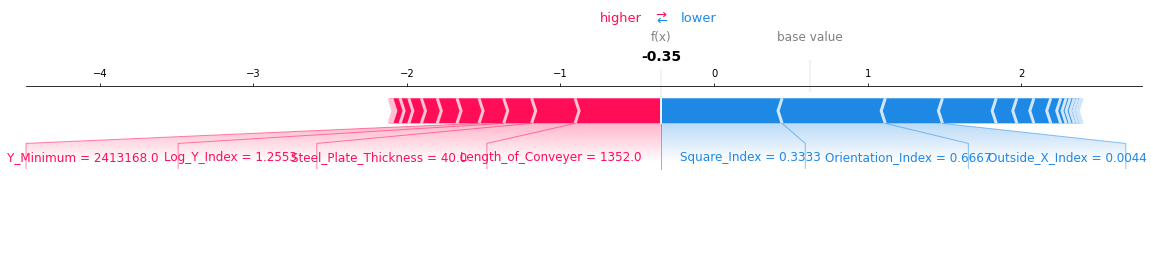

Dirtiness

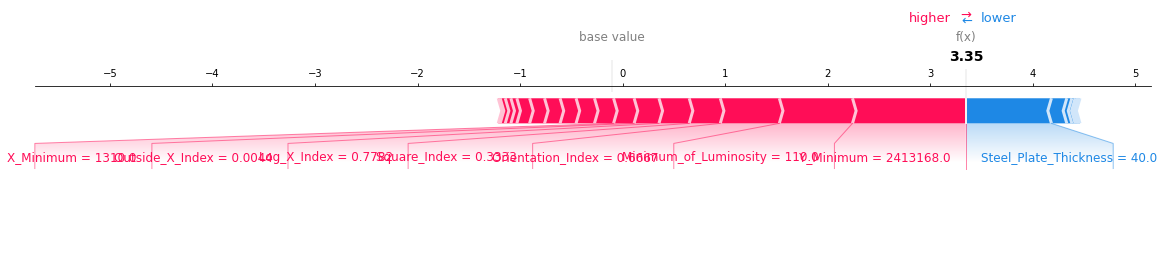

K_Scratch

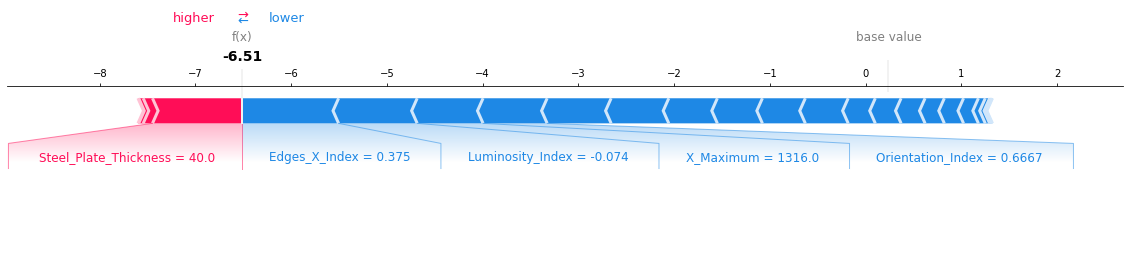

Other_Faults

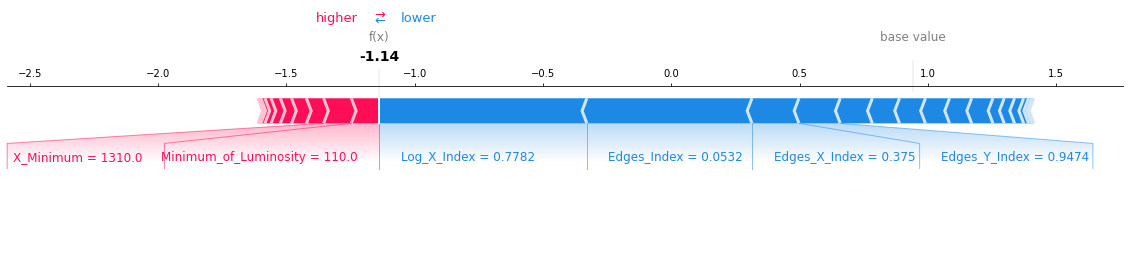

Pastry

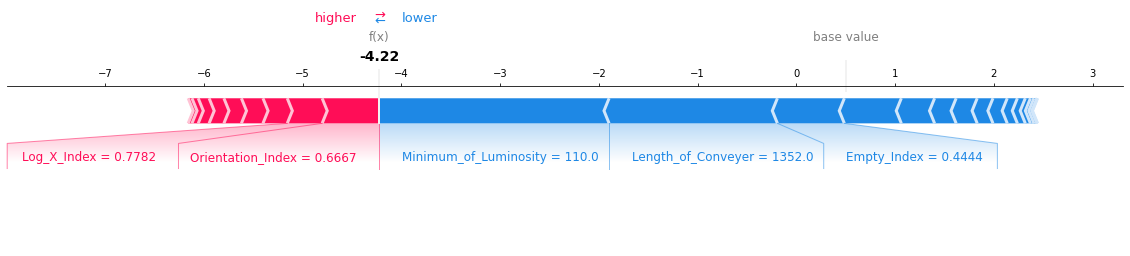

Stains

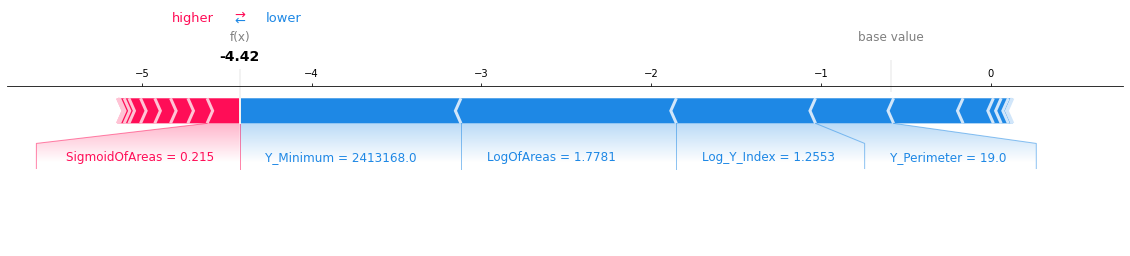

Z_Scratch

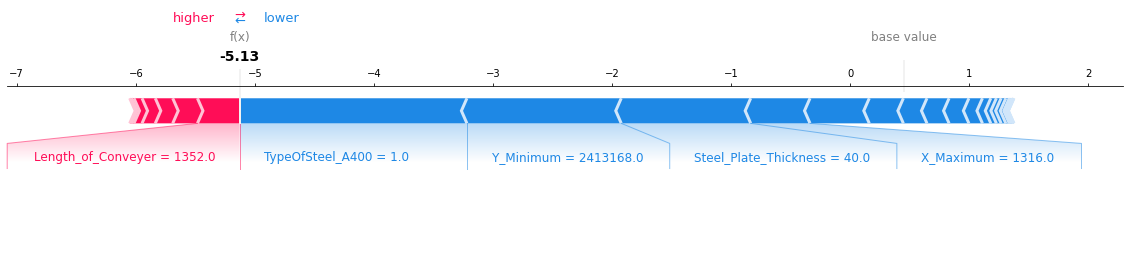

In [0]:
def force_plot_all_labels(observation=0, force_plot=True):
    for i, label in enumerate(class_names):
        print(label)
        if force_plot:
            shap.force_plot(explainer.expected_value[i], shap_values[i][observation], matplotlib=True, feature_names=X_test.columns, features=X_test.iloc[observation].to_numpy())
        else:
            shap.plots._waterfall.waterfall_legacy(explainer.expected_value[i], shap_values[i][observation], feature_names=X.columns, features=X.iloc[observation].to_numpy())

force_plot_all_labels(0, force_plot=True)

In [0]:
# print(shap_values[0][0])
# shap: 7 (classes) > 1801 (dateset) > 27 (observations) 

In [0]:
explainer_generic = shap.Explainer(model, X_test)
shap_obj = explainer_generic(X_test)

In [0]:
clustering = shap.utils.hclust(X_test, y_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models

15%|█▍ | 4/27 [00:00<?, ?it/s] 22%|██▏ | 6/27 [00:15<00:32, 1.57s/it] 26%|██▌ | 7/27 [00:19<00:45, 2.28s/it] 30%|██▉ | 8/27 [00:22<00:52, 2.77s/it] 33%|███▎ | 9/27 [00:25<00:53, 2.95s/it] 37%|███▋ | 10/27 [00:29<00:51, 3.04s/it] 41%|████ | 11/27 [00:31<00:47, 2.96s/it] 44%|████▍ | 12/27 [00:35<00:47, 3.15s/it]

Bumps

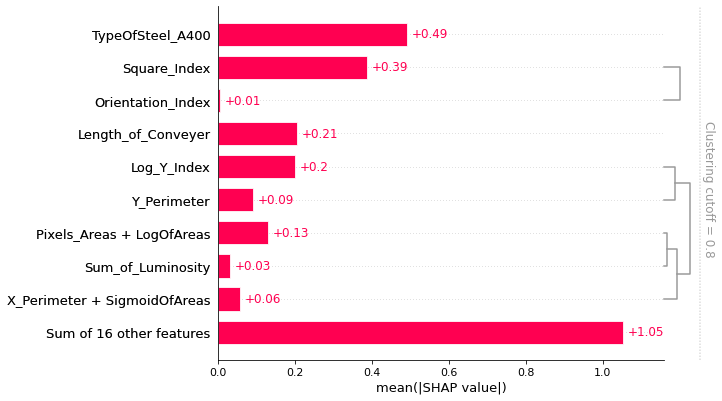

In [0]:
def print_plots(i_label=0) -> None:
    print(class_names[i_label])
    shap.plots.bar(shap_obj[:, :, i_label], clustering=clustering, clustering_cutoff=0.8)
#     shap.plots.bar(shap_obj[:, :, i_label].cohorts(2).abs.mean(0))
#     shap.plots.bar(shap_obj.cohorts(2).abs.mean(0))

# for i in range(7):
for i in range(1):
    print_plots(i_label=i)

In [0]:
from typing import Union
print(class_names)  
def plot_scatter(label: str, feature: Union[str, int], color=None, use_max=False) -> None:
    index = class_names.index(label)
    
    title = ""
    selector = shap_obj[:, "Steel_Plate_Thickness", index]
    if isinstance(feature, str):
        selector = shap_obj[:, feature, index]
    elif isinstance(feature, int):
        title = f"Top {-feature} Feature"
        if use_max:
            selector = shap_obj[:, shap_obj[:, :, index].abs.max(0).argsort.values[feature], index]
            title = f"| {title} (max impact)"
        else:
            selector = shap_obj[:, shap_obj[:, :, index].abs.mean(0).argsort.values[feature], index]
            title = f"| {title} (mean impact)"
    
    if isinstance(color, str):
        shap.plots.scatter(selector, color=shap_obj[:, color, index], show=False)
    elif color:
        shap.plots.scatter(selector, color=shap_obj[:, :, index], show=False)
    else:
        shap.plots.scatter(selector, show=False)
    plt.title(f"Label: {label} {title}")
    plt.show()


plot_scatter("Bumps", feature=-1, color=True, use_max=False)
plot_scatter("Bumps", feature=-1, color=True, use_max=True)
plot_scatter("Bumps", feature="Steel_Plate_Thickness", color="Length_of_Conveyer")

plot_scatter("K_Scratch", feature=-1, color=True, use_max=False) # same as max
# plot_scatter("K_Scratch", feature=-1, color=True, use_max=True)

plot_scatter("Z_Scratch", feature=-1, color=True, use_max=False) # same as max
plot_scatter("Z_Scratch", feature=-1, color=True, use_max=True)


plot_scatter("Pastry", feature=-1, color=True, use_max=False) # same as max
# plot_scatter("Pastry", feature=-1, color=True, use_max=True)

plot_scatter("Other_Faults", feature=-1, color=True, use_max=False) # same as max
# plot_scatter("Other_Faults", feature=-1, color=True, use_max=True)